## Project 2018 - "Programming For Data Analysis"

### A Notebook by: Marco Men

### Date Of Last Commit: 14th December 2018

## Introduction

In this notebook I will be choosing a  real-world phenomenon ( stock price fluctuations ) and strategy creation based on real data.
I will be :
 *  Investigating the types of variables involved ( their distributions and relationships with each other ) ;
 *  Simulating/synthesising the dataset as closely matching their properties as possible ;
 *  And detailing my research and implement the simulation in this Jupyter notebook .

Before I continue, I must give you some insight on the Python package used to download and retrieve the historical stock information ( S&P500 ) and why. 

The package I am refering to is called "fix-yahoo-finance", created by Ran Aroussi to provide a fix to "Pandas Datareader ( "get_data_yahoo()" ) . This Pandas Datareader command relied on Yahoo!Finance API, which has been decommissioned after AOL's acquisition of Yahoo.

This package must be installed on your machine, if you intend to download/clone this notebook and run it locally.

As the package is not part of Anaconda version of python, only pip install works ( not conda install ). More information can be found [here](https://pypi.org/project/fix-yahoo-finance/). 

If the previous method does not work, an alternative method is to clone a [GitHub folder](https://github.com/ranaroussi/fix-yahoo-finance) into your machine and run either "python setup.py install" inside your cloned folder.


# The Story For The Simulation

I believe every simulation should start with a story. The story is fictitious, so I had to use my imagination and creativity.

Let's say I work in a stock trading firm in the "quant" department. I was asked to come up with a predictor algorithm that provides trading signals, that after being tested could be implemented to provide "signals" for any trade.  

I will be measuring the performance of the market based on historical price information and use this information for backtesting purposes ( our strategies versus actual market performance )

First, I will be using Standard & Poor's 500 ( S&P500 ) , which is considered to be a good proxy for the whole stock market in the United States, due to the high number of names included in the index and the total market capitalisation represented by it.
It also has highly liquid futures and option markets.
I will be using S&P500 as a base for my dataset. I will use the close column,which I will investigate ( its distribution and summary of descriptive statistics ) and attempt to replicate as closely as possible using numpy.random() package.

But before I continue, I must provide a brief explanation on certain terms you **may / may not** be familiar. The terms are :

  *  Backtesting ;
  *  Moving Averages ;
  *  Market Log Returns ;
  *  Market Regime ;
  *  And also, the Pandas "shift()" method .  
  
## Backtesting

Part of creating a strategy  after the design phase testing is required. A way to do this is is through "backtesting". So, we implement the strategy created on historical real data readily available to us  to test how well our strategy would behave under known market conditions, before implementation on future forecasts ( unknown expected market conditions ) .


## Moving Averages

The strategy can be created using past information gathered and an average calculated based on averages of a particular time interval. In the following notebook, I will be using a 21-days and 126-days moving averages . Moving averages may be referred to in other literature as rolling days. The method is simple, for the 21-days you simply add the first 21 days 'close' variables and average them, by dividing by 21. You will get your first 21-days moving average on the $22^{nd}$ term and then you jump from the first term to the second and do the same in a sequence until no more terms are available. The same is done for the 126-days,but the sum is on 126 terms averaged by 126 in sequence until no more terms are available. 


In [ ]:
# https://stackoverflow.com/questions/49705047/downloading-mutliple-stocks-at-once-from-yahoo-finance-python

import numpy as np
import pandas as pd
from pandas_datareader import data as pdr
import fix_yahoo_finance as yf
import matplotlib.pyplot as plt

yf.pdr_override()




tickers = ['^GSPC']

start_date = '2000-01-01'
end_date = '2018-09-30'

# User pandas_reader.data.DataReader to load the desired data. As simple as that.
SP500 = pdr.get_data_yahoo(tickers,start=start_date, end=end_date)


SP500.info()
SP500['Close'].plot(grid=True, figsize=(14,10))
SP500['Close'].plot()
SP500['Close'].plot.density()
SP500['Close'].describe()

In [ ]:
SP500.info()

In [ ]:
SP500['Close'].plot(grid=True, figsize=(14,10))


Since my goal is to try and replicate the Close column from SP500. I must conduct an investigation on the type of distribution and summary of descriptive statistics to help me choose what type of numpy random package to use and parameters.

In [ ]:
SP500['Close'].plot()

In [ ]:
SP500['Close'].plot.density()

The plot above looks like a multivariate normal distribution, but not your ususal "bell-shaped" curve. This may be because of several graphs plotted over each other. Remember SP500 is a compilation of 500 companies ranked by Standard & Poor index.

In [ ]:
SP500['Close'].describe()

To recap, the number of rows is 4,716 with a mean of 1,488 and standard deviation of 494. The minimum value is 676.53 and the maximum is 2,930.75. The best method to create a simulated version of this will be numpy.random.randn

In [316]:
import numpy as np

# The parameters above are maximum number is 2,520.75 as above (( 2,254.22 + 676.53) * .7 )
# The minimum value is 676.53 as above 
# The standard deviation is 467 - closely as above
# The mean is around 1480 as above
index =  pd.date_range(start='1/1/2000', end=1/9/2018,freq='D',)

 
simul_df = pd.DataFrame( np.random.randint(low=676, high=2930, size=(4716,1)),
                    columns=['Close'])
    

np.max(simul_df)
simul_df

,Close
0,2263
1,2757
2,807
3,785
4,2226
5,2141
6,2766
7,2349
8,2074
9,1359


In [317]:
np.min(simul_df)

Close    676
dtype: int32

In [318]:
np.std(simul_df)

Close    652.330011
dtype: float64

In [319]:
np.mean(simul_df)

Close    1796.008058
dtype: float64

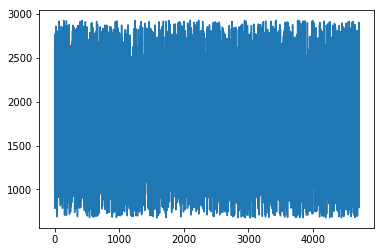

In [323]:
import matplotlib.pyplot as plt


simul_df['Close'].plot()



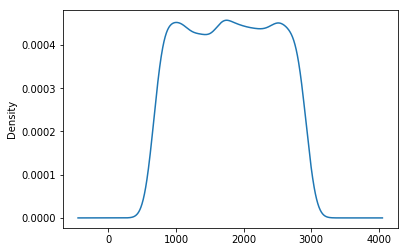

In [324]:
simul_df['Close'].plot.density()

We want to implement a strategy based on both one-month(21 trading days) and six-months(126 trading days) trends. So, I will be calculating both moving averages.

In [4]:
# Moving Averages for 21 days and 126 days


SP500['21d'] = np.round(SP500['Close'].rolling(21).mean(), 2)
SP500['126d'] = np.round(SP500['Close'].rolling(126).mean(), 2)

The two extra columns created only start at those dates when 21 and 126 observation points ,respectively, are available for the first time to calculate their averages ( or means )

In [5]:
# I have created another two columns


SP500[['Close', '21d', '126d']].tail()

,Close,21d,126d
Date,,,
2018-09-24,2919.370117,2898.32,2767.73
2018-09-25,2915.560059,2900.26,2770.14
2018-09-26,2905.969971,2900.70,2772.53
2018-09-27,2914.000000,2901.49,2774.69
2018-09-28,2913.979980,2901.48,2777.33


Plotting the new data created above will provide some insights in terms of what happened in the past with regards to **upward** and **downward** trends.

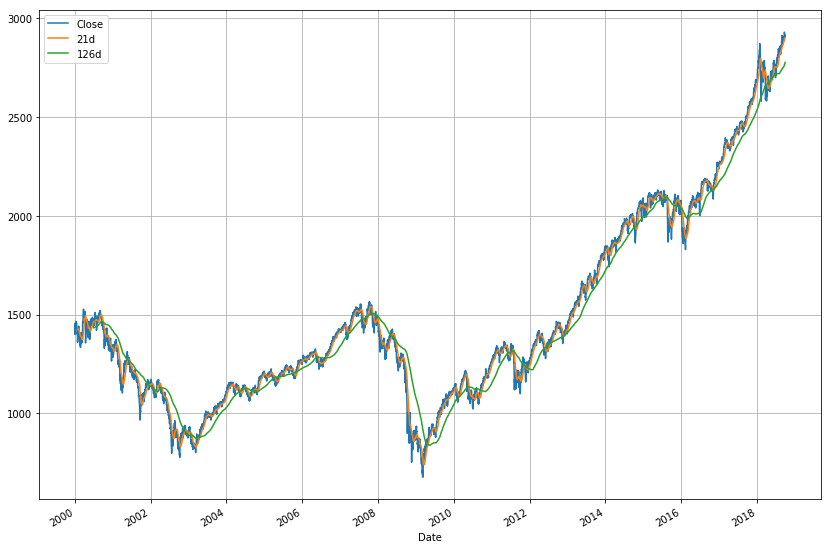

In [6]:
SP500[['Close', '21d', '126d']].plot(grid=True,figsize=(14,10))

To recap, the 'Close' is simply the actual historical stock prices of S&P500 index from the start of 2000 until the end of September 2018.

My strategy with the moving averages(21 days and 126 days) is then overlapped on the plot. And now we can devise a rule to generate trading signals:

* Buy signal ( go long )
    The 21d trend is for the first time *SD points above* 126d trend.
    
* Wait ( park in cash )
    The 21d trend is within a range of +/- *SD points around* the 126d trend.
    
* Sell signal ( go short )
    The 21d trend is for the first time *SD points below* the 126d trend 
    
Next, I need to add another column to the trend dataframe with the differences between the two trends ( 42d - 126d).



In [7]:
SP500['21-126'] = SP500['21d'] - SP500['126d']
SP500['21-126'].tail()

Date
2018-09-24    130.59
2018-09-25    130.12
2018-09-26    128.17
2018-09-27    126.80
2018-09-28    124.15
Name: 21-126, dtype: float64

The first number of rows ( 126 to be precise )in the dataframe will be assigned 'NaN' by pandas as the calculation of the statistics is only started to be calculated after the 21 and 126 observation points on the 'Close' column occurred ( As seen on the next code ). 

In [8]:
SP500['21-126'].head(126)

Date
2000-01-03      NaN
2000-01-04      NaN
2000-01-05      NaN
2000-01-06      NaN
2000-01-07      NaN
2000-01-10      NaN
2000-01-11      NaN
2000-01-12      NaN
2000-01-13      NaN
2000-01-14      NaN
2000-01-18      NaN
2000-01-19      NaN
2000-01-20      NaN
2000-01-21      NaN
2000-01-24      NaN
2000-01-25      NaN
2000-01-26      NaN
2000-01-27      NaN
2000-01-28      NaN
2000-01-31      NaN
2000-02-01      NaN
2000-02-02      NaN
2000-02-03      NaN
2000-02-04      NaN
2000-02-07      NaN
2000-02-08      NaN
2000-02-09      NaN
2000-02-10      NaN
2000-02-11      NaN
2000-02-14      NaN
              ...  
2000-05-19      NaN
2000-05-22      NaN
2000-05-23      NaN
2000-05-24      NaN
2000-05-25      NaN
2000-05-26      NaN
2000-05-30      NaN
2000-05-31      NaN
2000-06-01      NaN
2000-06-02      NaN
2000-06-05      NaN
2000-06-06      NaN
2000-06-07      NaN
2000-06-08      NaN
2000-06-09      NaN
2000-06-12      NaN
2000-06-13      NaN
2000-06-14      NaN
2000-06-15     

Let me make it more formal and generate another column called *regime*, where we will assume a value of 34 for the signal threshold.

In [9]:
SD = 34
SP500['Regime'] = np.where(SP500['21-126'] > SD, 1, 0)
SP500['Regime'] = np.where(SP500['21-126'] < -SD, -1, SP500['Regime'])
# for value counts
SP500['Regime'].value_counts()

 1    2144
 0    1754
-1     818
Name: Regime, dtype: int64

What the value counts ( above ) mean is that, on 2,144 trading dates, the 21d trend lies more than SD points ( 34 ) above the 126d trend. On 1,754 days, the 21d trend is more than SD points ( 34 ) below the 126d trend. Usually, if the short-term trend crosses the line of the log-term trend it tends to rest there for a while. This is the *regime* and can be represented as follows:

(-1.1, 1.1)

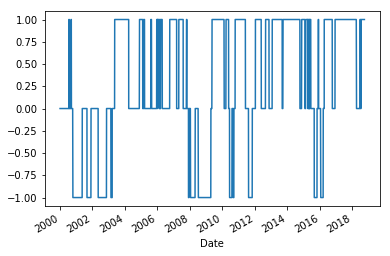

In [10]:
SP500['Regime'].plot(lw=1.5)
plt.ylim([-1.1,1.1])

Now I have everything ready to test the investment strategy based on the signals. For simplicity purposes, we will assume that an investor can directly invest in the index or can directly short the index, which in the real world must be accomplished by using index funds, exchange-traded funds, or futures on index. Such trades lead to transaction costs that are neglected here.
Based on our ***regime***, the *investor is either **long** or **short** in the market or parks his wealth in cash ( bears no interest )*.
The investor makes the market return when (s)he is **long**(1), make negative market returns when (s)he is **short**(-1), and makes no returns(0), when (s)he parks his/her wealth in cash.
I will need the market returns calculated for every single trading day to get the daily log returns.

In [11]:
SP500['Market'] = np.log(SP500['Close'] / SP500['Close'].shift(1))

To get the returns of the trend-based strategy, I just multiply the 'Regime' column, shifted by one day, by the 'Returns' columns ( the position is built "yesterday" and yields "today's" returns ).

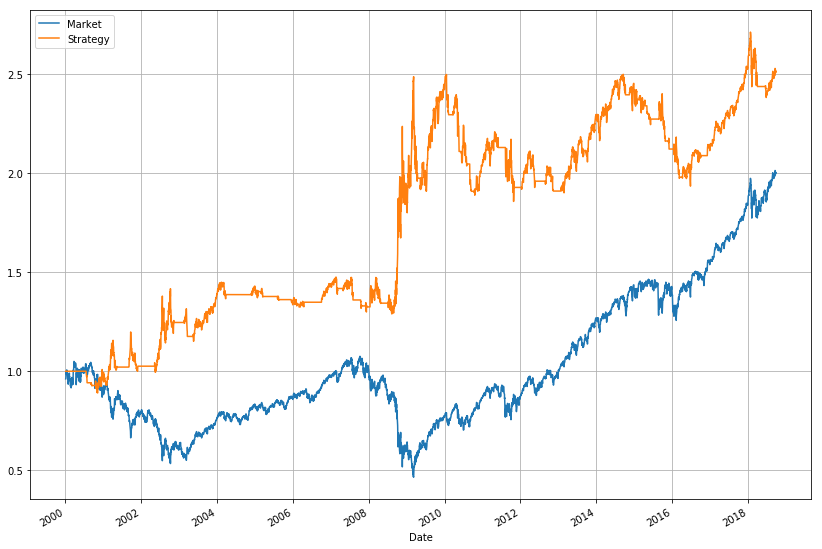

In [12]:
SP500['Strategy'] = SP500['Regime'].shift(1) * SP500['Market']

# And now for the plotting

SP500[['Market', 'Strategy']].cumsum().apply(np.exp).plot(grid=True,figsize=(14,10))

The investor is able to lock in a much higher return over the relevant period than a plain long investment would provide. The plot above shows us a comparison between the cumulative continuous returns of the index against the cumulative continuous returns from our strategy.
During market downturns ( around 2003 and 2008/2009 ) the **shorting** of the market yields quite high returns. The strategy as a whole outperforms the market quite significantly.

Below I will be subsetting my DataFrame, which I will call 'simul_df' ( for simulation Data Frame). It will include the 'Close' column from SP500 and the synthesied data ('21d', '126d', '21-126', 'Regime','Market','Strategy')

In [36]:
# My fake dataset

simul_df = SP500[['Close','21d','126d','21-126','Regime','Market','Strategy']]

simul_df.info()

simul_df=simul_df.dropna() # This dataset only starts 126 days in the time series after because of NaNs dropped

simul_df.head()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4716 entries, 2000-01-03 to 2018-09-28
Data columns (total 7 columns):
Close       4716 non-null float64
21d         4696 non-null float64
126d        4591 non-null float64
21-126      4591 non-null float64
Regime      4716 non-null int32
Market      4715 non-null float64
Strategy    4715 non-null float64
dtypes: float64(6), int32(1)
memory usage: 276.3 KB


,Close,21d,126d,21-126,Regime,Market,Strategy
Date,,,,,,,
2000-06-30,1454.599976,1462.59,1433.30,29.29,0,0.008429,0.0
2000-07-03,1469.540039,1462.22,1433.41,28.81,0,0.010219,0.0
2000-07-05,1446.229980,1461.20,1433.78,27.42,0,-0.015989,-0.0
2000-07-06,1456.670044,1461.14,1434.22,26.92,0,0.007193,0.0
2000-07-07,1478.900024,1461.50,1434.81,26.69,0,0.015146,0.0


Next I will plot the density distribution for both Market and Strategy.

<Figure size 1008x720 with 0 Axes>

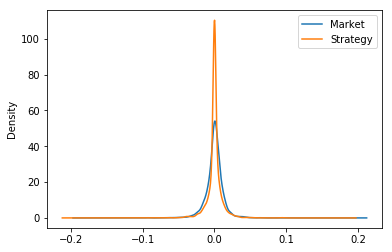

In [28]:
plt.figure(figsize=(14,10))
simul_df[['Market', 'Strategy']].plot.density()
plt.show()

Both are normally distributed and are approximated. With the strategy density plot showing a higher density peak. These are based on 'Market' and 'Strategy' log returns.

<Figure size 1008x720 with 0 Axes>

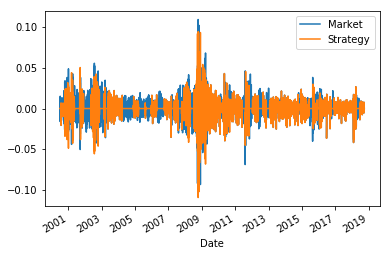

In [29]:
plt.figure(figsize=(14,10))
simul_df[['Market', 'Strategy']].plot()
plt.show()

In [2]:
# https://stackoverflow.com/questions/49705047/downloading-mutliple-stocks-at-once-from-yahoo-finance-python

import numpy as np
import pandas as pd
from pandas_datareader import data as pdr
import fix_yahoo_finance as yf
import matplotlib.pyplot as plt

yf.pdr_override()



# Nissan stock prices
tickers = ['NSANY']

start_date = '2000-01-01'
end_date = '2018-09-30'

# User pandas_reader.data.DataReader to load the desired data. As simple as that.
nis = pdr.get_data_yahoo(tickers,start=start_date, end=end_date)
nis.info()

[*********************100%***********************]  1 of 1 downloaded
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4716 entries, 2000-01-03 to 2018-09-28
Data columns (total 6 columns):
Open         4716 non-null float64
High         4716 non-null float64
Low          4716 non-null float64
Close        4716 non-null float64
Adj Close    4716 non-null float64
Volume       4716 non-null int32
dtypes: float64(5), int32(1)
memory usage: 239.5 KB



Now I will check what type of distribution the 'Close' column forms and gather information from the descriptive statistics to be used in my modelling ( standard deviation and mean ). But first I will see what type of log returns ('Market' column ) plot Nissan has.

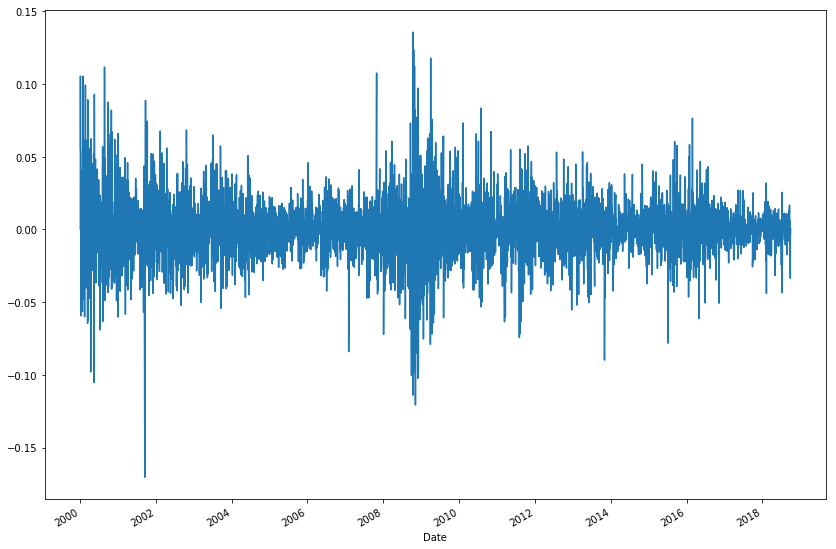

In [9]:
 # Another way to calculate log returns and we drop the NAs
    
nis['Market'] = np.log(nis.Close).diff()

nis = nis.dropna()


# The Market log returns

plt.figure(figsize = (14,10))
nis.Market.plot()
plt.show()

A classical daily return plot. Let's check the density plot.

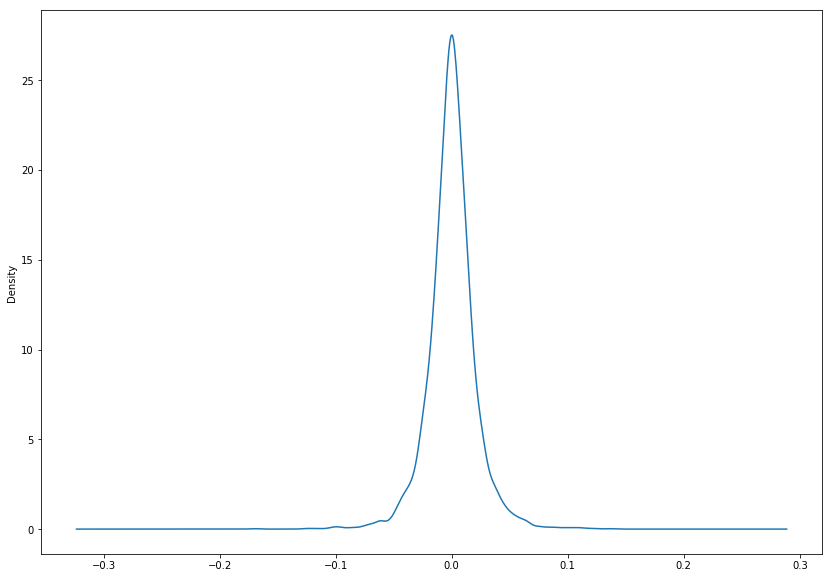

In [10]:
# The real Nissan market returns density plot

plt.figure(figsize = (14,10))
nis.Market.plot.density()
plt.show()


The distribution of close stock price appears to be normal distribution with mean around than 0 and standard deviation of around 0.1. But as being the sceptical that I am, I will double check by asking Pandas. Depending on the results I will get, I will eiter use randn or random_normal. I will be following numpy.org guidance when generating numbers ( pseudo ) randomly. So, I will need the standard deviation and the mean of the distribution above

In [11]:
nis.Market.describe()

count    4714.000000
mean        0.000183
std         0.020801
min        -0.170383
25%        -0.009921
50%         0.000000
75%         0.010214
max         0.135657
Name: Market, dtype: float64


This is a classic Normal Distribution. Mean around 0, standard deviation around 0.02 and counts of 4,715. My simulation will be slightly smaller. I plan to have 350 values with similar distribution ( slightly less count than the Nissan dataset ).

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 350 entries, 0 to 349
Data columns (total 3 columns):
Original_Close    350 non-null float64
Sample_Close      350 non-null float64
Mine_Close        350 non-null float64
dtypes: float64(3)
memory usage: 8.3 KB


<Figure size 1440x720 with 0 Axes>

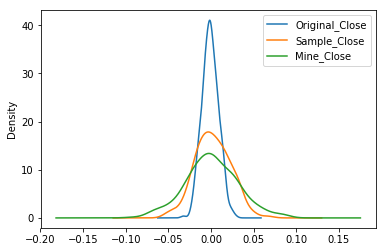

In [84]:
# Simulation of 'Close' column

de_1 = pd.Series(np.random.normal(0,0.01,350),name = 'Original_Close')


de_2 = pd.Series(np.random.normal(0,0.02,350),name = 'Sample_Close')


de_3 = pd.Series(np.random.normal(0,0.03,350),name = 'Mine_Close')



df = pd.concat([de_1,de_2,de_3],axis = 1)
df.info()
plt.figure(figsize=(20,10))
df.plot.density()
plt.show()

In [93]:
df.describe()

,Original_Close,Sample_Close,Mine_Close
count,350.000000,350.000000,350.000000
mean,-0.000778,0.002268,0.001006
std,0.009627,0.020932,0.030855
min,-0.032210,-0.053542,-0.092440
25%,-0.007491,-0.011743,-0.017748
50%,-0.000785,0.001134,0.000065
75%,0.005495,0.016863,0.021512
max,0.028411,0.068693,0.086029


The 'Original_Close' seems to be a good approximation of Nissan('Close') real information. 'Sample_Close' and 'Mine_Close' are slightly lower because of the standard deviation or Market volatility.
Next, I will plot the density distribution for Nissan's close price. And after that try and create similar type of information on my simulated dataset ( Close Prices ) to plot them.

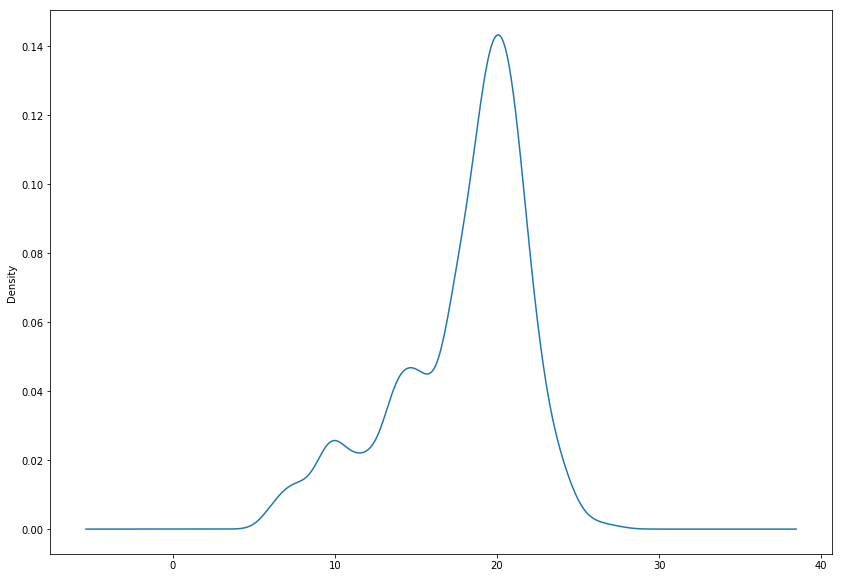

In [23]:
# The real Nissan close prices

plt.figure(figsize=(14,10))
nis.Close.plot.density()
plt.show()

In [24]:
nis.Close.describe()

count    4714.000000
mean       17.877197
std         4.078335
min         5.600000
25%        15.492500
50%        19.030001
75%        20.700001
max        27.500000
Name: Close, dtype: float64

In [ ]:
I will use the information from the summary of descriptive statistics to simulate 

In [85]:
# Simulation of 'Log Returns'

d1 = pd.Series( np.log(de_1).diff() + 17,name ='Original_Rets')
d2 = pd.Series( np.log(de_2).diff() + 17,name ='Sample_Rets')
d3 = pd.Series( np.log(de_3).diff() + 17,name ='Mine_Rets')

df2 = pd.concat([d1,d2,d3],axis=1)
df2=df2.fillna(df2.mean()) # Fill NA with mean numerical data of each series in df2, instead of dropping
df2.head()

C:\Users\User\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in log
  """Entry point for launching an IPython kernel.
C:\Users\User\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in log
  
C:\Users\User\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in log
  This is separate from the ipykernel package so we can avoid doing imports until


,Original_Rets,Sample_Rets,Mine_Rets
0,17.270825,17.008526,17.020023
1,17.270825,13.513531,17.020023
2,17.270825,17.008526,17.020023
3,17.270825,17.008526,14.461213
4,17.993181,17.561089,19.348280


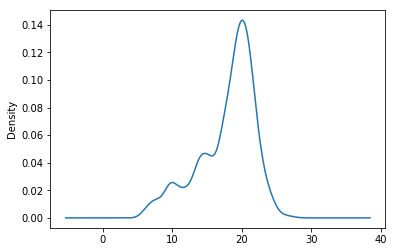

In [57]:
# The real Nissan close prices distribution

nis['Close'].plot.density()

<Figure size 1008x720 with 0 Axes>

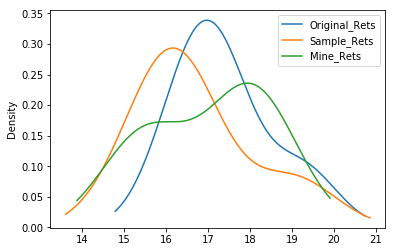

In [32]:
# Simulated close prices distributions for fake companies

plt.figure(figsize=(14,10))
df2.plot.density()
plt.show()

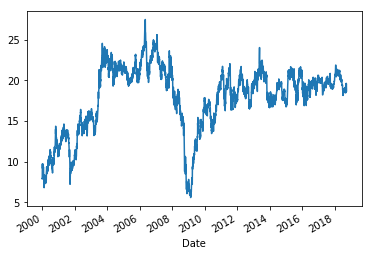

In [4]:
# Stock price fluctuations for Nissan
nis['Close'].plot()

<Figure size 1008x720 with 0 Axes>

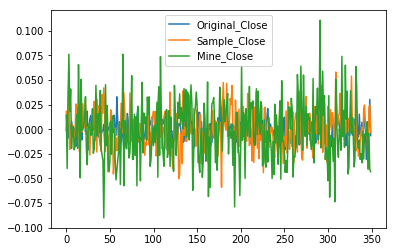

In [33]:
plt.figure(figsize=(14,10))
df.plot()
plt.show()

The plot above shows 3 simulations of potential variations of Nissan closing prices.
Mine PLC is the one company that presents the highest variance in terms of fluctuation of stock closing prices and then Sample PLC and the Original PLC plot is quite close to Nissan's data. This is made clear on the density graphs plotted above.

With this simulation, I can see the possible variations that the stock price can have in the future under current conditions.

Mine PLC would represent a market fluctuation with **high** risk and uncertainty, Sample PLC with **medium** risk.

In [92]:
# Create a time series index from the dataframes above

index = pd.date_range(1/1/2018, periods=350, freq='D')
data = pd.concat([df,df2],axis=1, join='inner')



data.info()

data.head()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 350 entries, 0 to 349
Data columns (total 6 columns):
Original_Close    350 non-null float64
Sample_Close      350 non-null float64
Mine_Close        350 non-null float64
Original_Rets     350 non-null float64
Sample_Rets       350 non-null float64
Mine_Rets         350 non-null float64
dtypes: float64(6)
memory usage: 16.5 KB


,Original_Close,Sample_Close,Mine_Close,Original_Rets,Sample_Rets,Mine_Rets
0,-0.011236,0.021853,0.014703,17.270825,17.008526,17.020023
1,0.012176,0.000669,-0.002702,17.270825,13.513531,17.020023
2,-0.003880,-0.044610,0.034560,17.270825,17.008526,17.020023
3,0.003917,0.012256,0.002729,17.270825,17.008526,14.461213
4,0.010574,0.021479,0.028565,17.993181,17.561089,19.348280
